# 多维向量版本的自动求导

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
plt.style.use('default')

In [2]:
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
     
        self.value = None
        self.gradients = {}

    def forward(self):
        raise NotImplemented

    def backward(self):
        raise NotImplemented

In [3]:
class Placeholder(Node):
    def __init__(self):
        Node.__init__(self)
    
    def forward(self, value=None):
        if value is not None:
            self.value = value

    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
    
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial

class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)

    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

In [4]:
def forward_and_backward(graph):
    for n in graph:
        n.forward()
    for n in graph[::-1]:
        n.backward()

In [5]:
def toplogic(graph):
    sorted_node = []
    
    while len(graph) > 0: 

        all_inputs = []
        all_outputs = []
        
        for n in graph:
            all_inputs += graph[n]
            all_outputs.append(n)
        
        all_inputs = set(all_inputs)
        all_outputs = set(all_outputs)
    
        need_remove = all_outputs - all_inputs  # which in all_inputs but not in all_outputs
    
        if len(need_remove) > 0: 
            node = random.choice(list(need_remove))

            need_to_visited = [node]

            if len(graph) == 1: need_to_visited += graph[node]
                
            graph.pop(node)
            sorted_node += need_to_visited
        
            for _, links in graph.items():
                if node in links: links.remove(node)
        else: # have cycle
            break
        
    return sorted_node

In [6]:
def convert_feed_dict_to_graph(feed_dict):
    computing_graph = defaultdict(list)
    nodes = [n for n in feed_dict]

    while nodes:
        n = nodes.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
    
    return computing_graph

In [7]:
def topological_sort_feed_dict(feed_dict):
    graph = convert_feed_dict_to_graph(feed_dict)
    
    return toplogic(graph)

In [8]:
def optimize(trainables, learning_rate=1e-2):
    for node in trainables:
        node.value += -1 * learning_rate * node.gradients[node]

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle, resample

In [10]:
dataset = fetch_openml(name='boston', version=1, as_frame=True, return_X_y=False, parser='pandas')

X_ = dataset['data'].apply(pd.to_numeric, errors='coerce').to_numpy()
y_ = np.array(dataset['target'])
feature_names = list(dataset.data.columns)

In [11]:
data = {
    'data': X_,
    'target': y_,
    'feature_names': feature_names,
    'DESCR': 'Boston Housing dataset fetch_openml',
    'filename': None
}

In [12]:
X_ = data['data']
y_ = data['target']

In [13]:
# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [14]:
losses = []

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        # _ = None
        forward_and_backward(graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

Epoch: 1, Loss: 154.138
Epoch: 101, Loss: 6.863
Epoch: 201, Loss: 4.661
Epoch: 301, Loss: 4.260
Epoch: 401, Loss: 4.365
Epoch: 501, Loss: 4.547
Epoch: 601, Loss: 3.526
Epoch: 701, Loss: 3.479
Epoch: 801, Loss: 3.080
Epoch: 901, Loss: 4.619
Epoch: 1001, Loss: 3.924
Epoch: 1101, Loss: 3.066
Epoch: 1201, Loss: 2.713
Epoch: 1301, Loss: 3.177
Epoch: 1401, Loss: 3.195
Epoch: 1501, Loss: 3.064
Epoch: 1601, Loss: 3.411
Epoch: 1701, Loss: 3.131
Epoch: 1801, Loss: 3.031
Epoch: 1901, Loss: 2.773
Epoch: 2001, Loss: 2.895
Epoch: 2101, Loss: 3.183
Epoch: 2201, Loss: 2.793
Epoch: 2301, Loss: 2.739
Epoch: 2401, Loss: 3.190
Epoch: 2501, Loss: 3.256
Epoch: 2601, Loss: 2.793
Epoch: 2701, Loss: 3.276
Epoch: 2801, Loss: 2.868
Epoch: 2901, Loss: 3.152
Epoch: 3001, Loss: 2.937
Epoch: 3101, Loss: 3.951
Epoch: 3201, Loss: 2.739
Epoch: 3301, Loss: 3.275
Epoch: 3401, Loss: 3.207
Epoch: 3501, Loss: 2.766
Epoch: 3601, Loss: 2.678
Epoch: 3701, Loss: 2.398
Epoch: 3801, Loss: 3.367
Epoch: 3901, Loss: 3.479
Epoch: 400

In [15]:
dataframe = pd.DataFrame(dataset['data'])

In [16]:
X_ = dataframe[['RM', 'LSTAT']]
y_ = data['target']

In [17]:
# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Placeholder(), Placeholder()
W1, b1 = Placeholder(), Placeholder()
W2, b2 = Placeholder(), Placeholder()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 200
# Total number of examples
m = X_.shape[0]
batch_size = 1
steps_per_epoch = m // batch_size

graph = topological_sort_feed_dict(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

Total number of examples = 506


In [18]:
from tqdm import tqdm

In [19]:
losses = []

for i in tqdm(range(epochs)):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        # _ = None
        forward_and_backward(graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        optimize(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss/steps_per_epoch)

  1%|          | 2/200 [00:00<00:31,  6.33it/s]

Epoch: 1, Loss: 39.024


 51%|█████     | 102/200 [00:12<00:11,  8.46it/s]

Epoch: 101, Loss: 13.488


100%|██████████| 200/200 [00:23<00:00,  8.36it/s]


In [20]:
from mpl_toolkits.mplot3d import Axes3D

In [21]:
X_.values

array([[ 0.41367189, -1.0755623 ],
       [ 0.19427445, -0.49243937],
       [ 1.28271368, -1.2087274 ],
       ...,
       [ 0.98496002, -0.98304761],
       [ 0.72567214, -0.86530163],
       [-0.36276709, -0.66905833]])

In [22]:
predicate_results = []
for rm, ls in X_.values:
    X.value = np.array([[rm, ls]])
    forward_and_backward(graph)
    predicate_results.append(graph[-2].value[0][0])

In [23]:
predicate_results

[25.97983547761153,
 22.082699411236174,
 33.12725125352179,
 32.420503338559726,
 31.75960216935204,
 24.60361153619225,
 20.305950048879517,
 15.41322631372944,
 11.964441028221783,
 16.518468029992082,
 14.554418955657704,
 20.015043469099354,
 17.921918153706024,
 20.650824427203062,
 20.605434438003925,
 20.58429524771896,
 20.990737158921725,
 18.944800163725624,
 20.472045834019767,
 20.474584382391257,
 12.492590678867384,
 19.726547851920213,
 15.67151794121946,
 13.942617706351426,
 17.228356550236626,
 17.43101149878153,
 19.084918749640273,
 16.394121982966496,
 20.355539490362627,
 22.028578353614655,
 12.100671498082784,
 20.083454143686644,
 11.942559729275752,
 15.506398746083727,
 14.043649378610436,
 20.554761339085502,
 20.462741542834003,
 20.570558803111865,
 20.54493884514622,
 27.199562556359417,
 34.045027045851484,
 28.915609866133043,
 22.24693881179472,
 21.54373552860403,
 20.645550775873847,
 20.510885625834042,
 19.695581449626467,
 15.498780205780314,
 11

Text(0.5, 0, 'Predicated-Price')

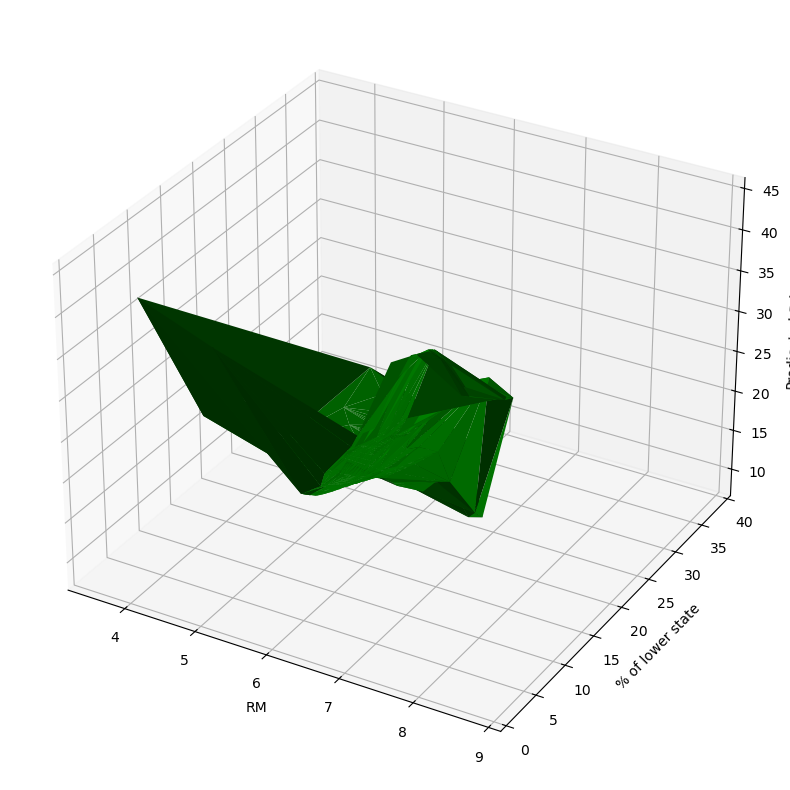

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

X_ = dataframe[['RM', 'LSTAT']].values[:, 0]
Y_ = dataframe[['RM', 'LSTAT']].values[:, 1]

Z = predicate_results

rm_and_lstp_price = ax.plot_trisurf(X_, Y_, Z, color='green')

ax.set_xlabel('RM')
ax.set_ylabel('% of lower state')
ax.set_zlabel('Predicated-Price')

![欢迎订阅：坍缩的奇点](../assets/Capture-2023-11-02-164446.png)